In [3]:
from BcomMEG import *
import mne
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
# dir = '/Volumes/@neurospeech/PROJECTS/BCI/BCOM/DATA_ANALYZED/EVOKED/DATA/WITHOUT_BADS/COVERT'
dir1 = '/Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample'
epo_files = []
subjects = ['BCOM_18_2']
avoid_reading = False
for subject in subjects:
    for root, dirs, files in os.walk(dir1):
            for file in files:
                if file.startswith(subject):
                    epo_name = file[10:-8]

                    if (avoid_reading == True) and (sum(c.isdigit() for c in epo_name) < 3): #segments where the subject is actually just reading rather than imagining have 2 digits
                        continue
            
                    file = os.path.join(dir1, file)
                    epo_files.append(file)

In [5]:
# Reading in Epochs
epoch_1 = mne.read_epochs(epo_files[0])

Reading /Users/ciprianbangu/Cogmaster/M2 Internship/BCI code/Data_Sample/BCOM_18_2_ma_32-epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
18 matching events found
No baseline correction applied
0 projection items activated


In [6]:
epoch_1
magnetometer_names = [ch_name for ch_name in epoch_1.ch_names if ch_name.startswith('MEG')]
magnetometer_orders = [epoch_1.ch_names.index(name) for name in magnetometer_names]

print("Magnetometer Names:", magnetometer_names)
print("Magnetometer Orders:", magnetometer_orders)

Magnetometer Names: ['MEG 001', 'MEG 002', 'MEG 003', 'MEG 004', 'MEG 005', 'MEG 006', 'MEG 007', 'MEG 008', 'MEG 009', 'MEG 010', 'MEG 011', 'MEG 012', 'MEG 013', 'MEG 014', 'MEG 015', 'MEG 016', 'MEG 017', 'MEG 018', 'MEG 019', 'MEG 020', 'MEG 021', 'MEG 022', 'MEG 023', 'MEG 024', 'MEG 025', 'MEG 026', 'MEG 027', 'MEG 028', 'MEG 029', 'MEG 030', 'MEG 031', 'MEG 032', 'MEG 033', 'MEG 034', 'MEG 035', 'MEG 036', 'MEG 037', 'MEG 038', 'MEG 039', 'MEG 040', 'MEG 041', 'MEG 042', 'MEG 043', 'MEG 044', 'MEG 045', 'MEG 046', 'MEG 047', 'MEG 048', 'MEG 049', 'MEG 050', 'MEG 051', 'MEG 052', 'MEG 053', 'MEG 054', 'MEG 055', 'MEG 056', 'MEG 057', 'MEG 058', 'MEG 059', 'MEG 060', 'MEG 061', 'MEG 062', 'MEG 063', 'MEG 064', 'MEG 065', 'MEG 066', 'MEG 067', 'MEG 068', 'MEG 069', 'MEG 070', 'MEG 071', 'MEG 072', 'MEG 073', 'MEG 074', 'MEG 075', 'MEG 076', 'MEG 077', 'MEG 078', 'MEG 079', 'MEG 080', 'MEG 081', 'MEG 082', 'MEG 083', 'MEG 084', 'MEG 085', 'MEG 086', 'MEG 087', 'MEG 088', 'MEG 089', 

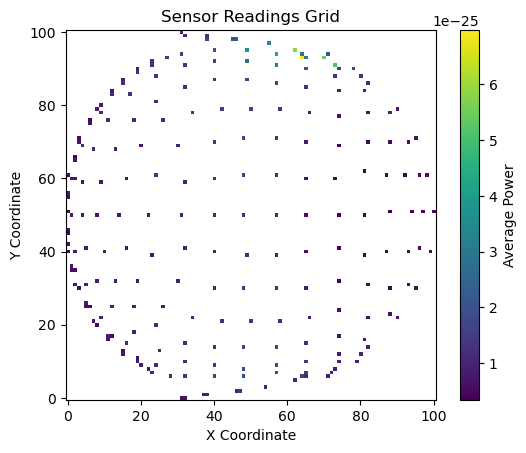

In [ ]:
# Get sensor positions
sensor_positions = epoch_1.info['chs']

# Extract x, y coordinates of the sensors
xy_coords = np.array([ch['loc'][:2] for ch in sensor_positions if ch['ch_name'] in magnetometer_names])

# Normalize coordinates to fit into a grid
xy_coords -= xy_coords.min(axis=0)
xy_coords /= xy_coords.max(axis=0)
xy_coords *= 100  # Scale to a 100x100 grid

# Create an empty grid
grid_size = (101, 101)
sensor_grid = np.full(grid_size, np.nan) 

# Fill the grid with sensor readings
for i, (x, y) in enumerate(xy_coords.astype(int)):
    sensor_grid[x, y] = power.data[i, :, :].mean(axis=0).mean(axis=0)  # Example: average power over frequencies and time

plt.imshow(sensor_grid, origin='lower', cmap='viridis')
plt.colorbar(label='Average Power')
plt.title('Sensor Readings Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

In [8]:
frequencies = np.array(range(2, 100, 2))  # Frequency range from 2 to 40 Hz, in steps of 2
n_cycles = frequencies / 5   # Number of cycles, adjust as needed
power = mne.time_frequency.tfr_morlet(
    epoch_1, 
    freqs=frequencies, 
    n_cycles=n_cycles, 
    use_fft=True, 
    return_itc=False,  # Only power, not inter-trial coherence
    decim=3,           # Decimate to reduce memory usage
    n_jobs=1           # Number of parallel jobs
)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


Applying baseline correction (mode: logratio)


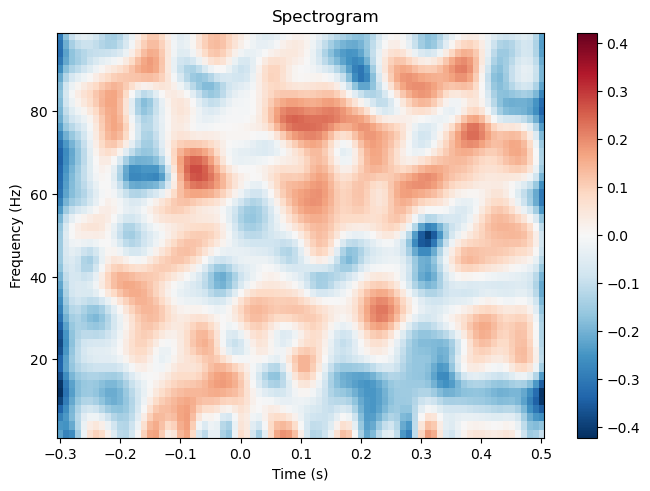

[<Figure size 640x480 with 2 Axes>]

In [14]:
power.plot(
    picks='MEG 006',  # Replace with specific channel name or type, e.g., 'MEG 1332'
    baseline=(None, 0),  # Baseline correction (optional)
    mode='logratio',     # Baseline normalization method
    title="Spectrogram"
)

In [41]:
tfr_data = power.data

In [42]:
tfr_data.shape #magnetometers by frequencies by time_bins
#So what if we take the represntation of all the magnetometers?
# How would that work then? I guess each of them would have a 247 dimensional representation? Or you just average over them?
# Idk if averaging really makes sense here but it would reduce it down to the 1 power
# Or we just use a 3D convolution? Like you stack them all so that instead
# of 3 color channels, its as though there were 247 of them?
# Or do we try to stitch them all together?


(247, 49, 81)

In [43]:
# Create a copy of the power object with baseline correction
power_baseline_corrected = power.copy().apply_baseline(
    baseline=(None, 0),  # Same baseline as in plot
    mode='logratio'      # Same normalization mode
)

# Now extract the baseline-corrected data
baseline_corrected_data = power_baseline_corrected.data

Applying baseline correction (mode: logratio)


In [44]:
baseline_corrected_data

array([[[-0.36951237, -0.30350155, -0.23135209, ..., -0.35209012,
         -0.37658522, -0.38218967],
        [-0.39524332, -0.31098496, -0.23068112, ..., -0.36014861,
         -0.40142538, -0.42997888],
        [-0.43326665, -0.32986659, -0.24193226, ..., -0.37168177,
         -0.42907025, -0.48372175],
        ...,
        [-0.29239406, -0.20071168, -0.14791291, ..., -0.0912155 ,
         -0.16553634, -0.27050823],
        [-0.31257112, -0.21907154, -0.16103502, ..., -0.09262246,
         -0.17793699, -0.29005347],
        [-0.34506589, -0.25542915, -0.1953049 , ..., -0.09694182,
         -0.18680907, -0.30018197]],

       [[-0.32202721, -0.24532545, -0.22681837, ..., -0.28727503,
         -0.30700397, -0.34545836],
        [-0.37232481, -0.27754571, -0.23357185, ..., -0.31692005,
         -0.35689481, -0.41216511],
        [-0.4386176 , -0.3237071 , -0.2539902 , ..., -0.35382704,
         -0.41635513, -0.49271625],
        ...,
        [-0.36758395, -0.28165523, -0.22702186, ..., -

In [45]:
power_baseline_corrected = power.copy().apply_baseline(
    baseline=(None, 0),
    mode='logratio'
)
data_from_baseline_correction = power_baseline_corrected.data

Applying baseline correction (mode: logratio)


In [46]:
channel_index = 0
print("Are arrays exactly equal?", 
      np.array_equal(
          data_from_baseline_correction[channel_index], 
          power_baseline_corrected.data[channel_index]
      )
)

Are arrays exactly equal? True


Applying baseline correction (mode: logratio)


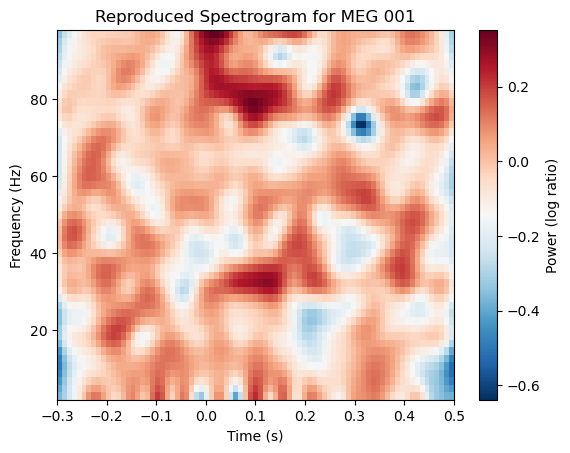

In [47]:
# Manually reproduce the plot for 'MEG 001'
channel_idx = power.ch_names.index('MEG 001')  # Find the channel index

# Extract raw data
raw_data = power.data[channel_idx, :, :]

# Apply baseline correction
power_corrected = power.apply_baseline(baseline=(None, 0), mode='logratio')
corrected_data = power_corrected.data[channel_idx, :, :]

# Plot corrected data
import matplotlib.pyplot as plt
plt.imshow(
    corrected_data,
    aspect='auto',
    origin='lower',
    extent=[power.times[0], power.times[-1], power.freqs[0], power.freqs[-1]],
    cmap='RdBu_r'
)
plt.colorbar(label='Power (log ratio)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Reproduced Spectrogram for MEG 001')
plt.show()

In [98]:
import torch.nn as nn
class BigTripletNet(nn.Module): #this one is designed to take in all the sensors as one big tensor
    def __init__(self):
        super(BigTripletNet, self).__init__()
        
        #Conv Blocks
        self.conv1 = nn.Conv2d(in_channels=247, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.act1 = nn.GELU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(16, 24, 40)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) 
        self.bn2 = nn.BatchNorm2d(32)
        self.act2 = nn.GELU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #(32, 12, 20)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.GELU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #64, 6, 10

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.act4 = nn.GELU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #128, 3, 5

        #FC layers
        self.fc1 = nn.Linear(1920, 512)
        self.fc2 = nn.Linear(512, 128)


    def forward(self, x):
        x = self.pool1(self.act1(self.bn1(self.conv1(x))))
        x = self.pool2(self.act2(self.bn2(self.conv2(x))))
        x = self.pool3(self.act3(self.bn3(self.conv3(x))))
        x = self.pool4(self.act4(self.bn4(self.conv4(x))))

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        print(x.shape)

        return x


In [99]:
model = BigTripletNet()

In [100]:
model.to(device='mps')
data = torch.tensor(data_from_baseline_correction, dtype=torch.float32)
data = data.to(device='mps')

In [1]:
# Add an extra dimension to the data tensor
data = data.unsqueeze(0)  # Add an extra dimension to the data tensor
data.shape

NameError: name 'data' is not defined

In [102]:
model(data)

torch.Size([1, 128])


tensor([[ 0.5340, -0.1571, -0.4861,  0.4363,  0.0455,  0.3874, -0.1402, -0.2919,
         -0.2654, -0.3802, -0.1191, -0.3442,  0.8937,  0.7089, -0.6383,  0.1493,
         -0.1862,  0.0138, -0.2385,  0.5055, -0.2366,  0.1213, -0.5600, -1.1846,
          0.2480, -0.5383,  0.1487,  0.1989, -0.1804, -0.0408,  0.0185,  0.4276,
          0.2146,  0.6647, -0.5078, -0.4014, -0.0204,  0.2452, -0.2439,  0.0123,
         -0.3380,  0.1554,  0.1999, -0.2314,  0.3361,  0.3895,  0.4610, -0.6637,
          0.7090, -0.2900,  0.5108,  0.1444, -0.2961, -0.1916, -1.0463, -0.0291,
         -0.1955, -0.7884, -0.0267,  0.2512,  0.0257,  0.4350,  0.0825,  0.8260,
          0.7408, -0.1746, -0.1979, -0.2789,  0.1306, -0.0055,  0.3905,  0.6522,
         -0.1001,  0.2987, -0.1067, -0.0682, -0.1999,  0.3542,  0.3543, -0.1683,
         -0.0475,  0.3658, -0.1471,  0.4864,  1.3819,  0.3530,  0.5918,  0.3983,
         -0.0049,  0.2658, -0.2764, -0.3923,  0.1244, -0.4531, -0.6760,  0.8823,
          0.0422, -0.1372, -